# 目的
OHLCとcross pointおよびその後の勢いとの相関を解析する。   
その解析結果をもとに、確実に利益の最小値がプラスになるスキームを構築する。

# 前回までのまとめ
`analysis of ohlc (201807-201811).ipynb`、`analysis of ohlc (20181224-20181231).ipynb`での解析の結果をまとめると次のようになる。

* Dead crossとgolden crossの両方とも、その前のいくつかのOHLCを見たときに現れないパターンがある。
* 平均的には、cross pointが現れたOHLCの直後にエントリーをすると、EMA(N=5,20)の差が最大または最小となる点において約定すると、dead crossの後は1000程度、golden crossの後は500~1000程度の利益が見込まれる。
* 約定のタイミングが最大・最小となる点より一つずれると、どちらも利益が下がるものの平均的には利確になりうる。
* したがってcross pointが現れたときに、見込みのあるパターンが形成されているならば出現直後にエントリーして、EMAの差が最大または最小となる点（利確点と呼ぶことにする）の前後で約定することで利益を得られそうである。
    + しかし利確点を狙い撃ちするにはまだ情報が足りない。
* 最初の最大・最小点を狙うと、順張りでは利益の最小値がマイナス、逆張りでは確実にマイナスになる。
* 以上から、別のスキームを探索する必要がある。


## このノートで調査する内容
* N1, N2を変え、最も利益の出る組み合わせを探す。

## モジュールと関数の用意

In [62]:
from datetime import datetime
import glob
import itertools
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import numpy as np
import os
import pandas as pd
import pickle

%matplotlib inline

In [60]:
from scipy.signal import lfilter

def calc_EMA(x, N=5):
    """calc_EMA(x, N) -> array-like
    calculate exponential moving average (EMA)
    
    Parameters
    ----------
    x : array-like
        target data series
    N : int (default : 5)
        step for EMA
    
    Returns
    -------
    EMA : array-like
    """
    return _calc_EMA(x, 2./(N + 1.))

def _calc_EMA(x, alpha):
    """ _calc_EMA(x, alpha) -> array-like
    calculate exponential moving average (EMA)
    Adopted from https://qiita.com/toyolab/items/6872b32d9fa1763345d8
    
    Parameters
    ----------
    x : array-like
        target data series
    alpha : float
        characteristic parameter
    
    Returns
    -------
    EMA : array-like
    """
    y,_ = lfilter([alpha], [1,alpha-1], x, zi=[x[0]*(1-alpha)])
    return y

def calc_SMA(df, key="Close", N=5):
    """calc_SMA(df, key="Close", N=5) -> numpy.1darray
    calculate simple moving average (SMA)
    
    Parameters
    ----------
    df : pandas.DataFrame
        dataframe including target data
    key : str (default : 'Close')
        key to the target data
    N : int (default : 5)
        step for SMA
    
    Returns
    -------
    SMA : numpy.1darray
    """
    return df[key].rolling(5).mean().values

def find_cross_points(y1, y2=None):
    """find_cross_points(y1, y2=None) -> numpy.1darray
    find cross points between two data sequences
    If y2 == None, then find the root of y1.
    
    Parameters
    ----------
    y1 : list or numpy.1darray
    y2 : list or numpy.1darray
    
    Returns
    -------
    cross_points : numpy.1darray
    """
    if y2 is None:
        y2 = np.zeros_like(y1)
    if isinstance(y1, list):
        y1 = np.array(y1)
    if isinstance(y2, list):
        y2 = np.array(y2)
    cross_points = np.zeros(len(y1))
    for ii in range(1, len(y1)):
        if y1[ii - 1] >= y2[ii - 1] and y1[ii] < y2[ii]:
            cross_points[ii] = -1
        elif y1[ii - 1] < y2[ii - 1] and y1[ii] >= y2[ii]:
            cross_points[ii] = 1
    return cross_points

In [3]:
def symbolize(dataFrame, k):
    """symbolize(dataFrame, k) -> numpy.1darray
    binalize a k-length OHLC dataset and then convert the binary to decimal number.  
    
    Parameters
    ----------
    dataFrame : pandas.DataFrame
    k : int
    
    Returns
    -------
    dec : numpy.1darray
    """
    if k <= 0:
        raise ValueError("k must be >=1.")
    var_ = (dataFrame["close"] - dataFrame["open"]).values
    dec = np.zeros(len(var_), int)
    
    for ii in range(k-1, len(var_)):
        ind_ = np.array(var_[ii-k+1:ii+1] >= 0, int)
        dec[ii] = int("".join([str(i_) for i_ in ind_]), 2)
    return dec

In [4]:
def peakdet(v, delta, x=None):
    """
        Converted from MATLAB script at http://billauer.co.il/peakdet.html
        Returns two np.arrays
        function [maxtab, mintab]=peakdet(v, delta, x)
        % PEAKDET Detect peaks in a vector
        % [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
        % maxima and minima ("peaks") in the vector V.
        % MAXTAB and MINTAB consists of two columns. Column 1
        % contains indices in V, and column 2 the found values.
        %
        % With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
        % in MAXTAB and MINTAB are replaced with the corresponding
        % X-values.
        %
        % A point is considered a maximum peak if it has the maximal
        % value, and was preceded (to the left) by a value lower by
        % DELTA.
        % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
        % This function is released to the public domain; Any use is allowed.
    """
    maxtab = []
    mintab = []
    if x is None:
        x = np.arange(len(v))
        v = np.asarray(v)
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN
    lookformax = True

    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        if lookformax:
            if this < mx - delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn + delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)

## メイン関数

In [10]:
def main(df, N1, N2, N_dec=5):
    """main(df, N1, N2, N_dec=5) -> dict
    calculate some factors
    """
    close_ = df["close"].values
    open_ = df["open"].values
    
    # calcualte EMA
    ema1 = calc_EMA(close_, N1)
    ema2 = calc_EMA(close_, N2)
    
    # find cross points
    cross_points = find_cross_points(ema1, ema2)
    ind_ = cross_points != 0
    a_k = np.vstack((np.arange(len(cross_points))[ind_], cross_points[ind_])).transpose().astype(int)
    
    # find local maxima and minima of the difference, "EMA1 - EMA2"
    ema_diff = ema1 - ema2
    maxtab_ema_diff, mintab_ema_diff = peakdet(ema_diff, 10)
    
    # symbolize
    dec = symbolize(df, N_dec)
    
    # extract factors for each godlen/dead cross points
    dec_ext = np.zeros(len(a_k), int)
    t1_ext = np.zeros(len(a_k), int)
    tm_ext = np.zeros(len(a_k), int)
    distance_ext = np.zeros(len(a_k), int)
    
    for ii in range(len(a_k)-1):
        ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
        v = a_k[ii][1]
        o_ = open_[ind1:ind2]
        c_ = close_[ind1:ind2]
        if v < 0: # dead cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = min(o_[1], c_[1])
            else:
                t1_ext[ii] = min(o_[0], c_[0])

            # minimum index
            index = (mintab_ema_diff[:, 0]>=ind1)&(mintab_ema_diff[:, 0]<ind2)
            count = index.sum()
            if count > 0:
                tm = (mintab_ema_diff[index, 0]).astype(int)[0]
            else:
                tm = ind1
            tm_ext[ii] = max(open_[tm+1], close_[tm+1])

        else: # golden cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = max(o_[1], c_[1])
            else:
                t1_ext[ii] = max(o_[0], c_[0])

            # maximum index
            index = (maxtab_ema_diff[:, 0]>=ind1)&(maxtab_ema_diff[:, 0]<ind2)
            count = index.sum()
            if count > 0:
                tm = (maxtab_ema_diff[index, 0]).astype(int)[0]
            else:
                tm = ind1
            tm_ext[ii] = min(open_[tm+1], close_[tm+1])
        distance_ext[ii] = tm - ind1 + 1

        dec_ext[ii] = dec[ind1]
    
    # calculate benefits
    benefits = tm_ext - t1_ext
    benefits[np.abs(benefits)>1e5] = 0.0
    
    # extract statistics and value-pattern pairs
    stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[::2]):
        v = benefits[::2][ii]
        list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

    for ii in range(len(list_ext_dead)):
        arr = list_ext_dead[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_dead[ii] = arr[ind]
            stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

    stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[1::2]):
        v = benefits[1::2][ii]
        list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

    for ii in range(len(list_ext_golden)):
        arr = list_ext_golden[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_golden[ii] = arr[ind]
            stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])
    
    results = dict(
        ema1=ema1, ema2=ema2, cross_points=cross_points, a_k=a_k,
        dec_ext=dec_ext, distance_ext=distance_ext, benefits=benefits,
        stat_dead=stat_dead, list_ext_dead=list_ext_dead,
        stat_golden=stat_golden, list_ext_golden=list_ext_golden
    )
    return results

In [11]:
def main_peak(df, N1, N2, N_dec=5):
    """main_peak(df, N1, N2, N_dec=5) -> dict
    calculate some factors for peak-contract scheme
    """
    close_ = df["close"].values
    open_ = df["open"].values
    
    # calcualte EMA
    ema1 = calc_EMA(close_, N1)
    ema2 = calc_EMA(close_, N2)
    
    # find cross points
    cross_points = find_cross_points(ema1, ema2)
    ind_ = cross_points != 0
    a_k = np.vstack((np.arange(len(cross_points))[ind_], cross_points[ind_])).transpose().astype(int)
    
    # find local maxima and minima of the difference, "EMA1 - EMA2"
    ema_diff = ema1 - ema2
    maxtab_ema_diff, mintab_ema_diff = peakdet(ema_diff, 10)
    
    # symbolize
    dec = symbolize(df, N_dec)
    
    # extract factors for each godlen/dead cross points
    dec_ext = np.zeros(len(a_k), int)
    t1_ext = np.zeros(len(a_k), int)
    tm_ext = np.zeros(len(a_k), int)
    distance_ext = np.zeros(len(a_k), int)
    
    for ii in range(len(a_k)-1):
        ind1, ind2 = a_k[ii][0], a_k[ii+1][0]
        v = a_k[ii][1]
        o_ = open_[ind1:ind2]
        c_ = close_[ind1:ind2]
        if v < 0: # dead cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = min(o_[1], c_[1])
            else:
                t1_ext[ii] = min(o_[0], c_[0])
            
            tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].min())[0]
            if tm != len(o_) - 1:
                tm_ext[ii] = max(o_[tm+1], c_[tm+1])
            else:
                tm_ext[ii] = max(o_[tm], c_[tm])

        else: # golden cross
            # start value
            if len(o_) > 1:
                t1_ext[ii] = max(o_[1], c_[1])
            else:
                t1_ext[ii] = max(o_[0], c_[0])

            tm = np.where(ema_diff[ind1:ind2]==ema_diff[ind1:ind2].max())[0]
            if tm != len(o_) - 1:
                tm_ext[ii] = min(o_[tm+1], c_[tm+1])
            else:
                tm_ext[ii] = min(o_[tm], c_[tm])
        distance_ext[ii] = tm - ind1 + 1

        dec_ext[ii] = dec[ind1]

    benefits = tm_ext - t1_ext
    benefits[np.abs(benefits)>1e5] = 0.0
    
    # extract statistics and value-pattern pairs
    stat_dead = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_dead = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[::2]):
        v = benefits[::2][ii]
        list_ext_dead[ind] = np.append(list_ext_dead[ind], v)

    for ii in range(len(list_ext_dead)):
        arr = list_ext_dead[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_dead[ii] = arr[ind]
            stat_dead[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])

    stat_golden = np.zeros((2**N_dec , 5), float) # max, min, mean, std, median
    list_ext_golden = [np.empty(0, dtype=float)] * 2**N_dec
    for ii, ind in enumerate(dec_ext[1::2]):
        v = benefits[1::2][ii]
        list_ext_golden[ind] = np.append(list_ext_golden[ind], v)

    for ii in range(len(list_ext_golden)):
        arr = list_ext_golden[ii]
        if len(arr) != 0:
            ind = np.abs(arr) <=100000
            list_ext_golden[ii] = arr[ind]
            stat_golden[ii] = np.array([arr[ind].max(), arr[ind].min(), arr[ind].mean(), arr[ind].std(), np.median(arr[ind])])
    
    results = dict(
        ema1=ema1, ema2=ema2, cross_points=cross_points, a_k=a_k,
        dec_ext=dec_ext, distance_ext=distance_ext, benefits=benefits,
        stat_dead=stat_dead, list_ext_dead=list_ext_dead,
        stat_golden=stat_golden, list_ext_golden=list_ext_golden
    )
    return results

## データの読み込み

In [7]:
df = pd.read_csv("../data/OHLCV_201812241200_to_201812311200.csv", index_col=0)
df.head()

,time,close,high,low,open,volumefrom,volumeto
0,2018-12-24T15:42:00.000000,467026,467090,466514,466699,228.61,1.067154e+08
1,2018-12-24T15:43:00.000000,467035,467400,466793,467026,383.26,1.790210e+08
2,2018-12-24T15:44:00.000000,466853,467045,466569,467035,229.46,1.071007e+08
3,2018-12-24T15:45:00.000000,466945,467021,466702,466853,192.55,8.989532e+07
4,2018-12-24T15:46:00.000000,467122,467346,466943,466945,303.19,1.416186e+08


In [8]:
df.tail()

,time,close,high,low,open,volumefrom,volumeto
9854,2018-12-31T11:56:00.000000,416478,417499,415800,417115,1175.35,4.896480e+08
9855,2018-12-31T11:57:00.000000,417646,417827,416000,416478,1025.69,4.275353e+08
9856,2018-12-31T11:58:00.000000,417111,417646,416978,417646,549.11,2.291352e+08
9857,2018-12-31T11:59:00.000000,417143,417211,416800,417111,331.31,1.381525e+08
9858,2018-12-31T12:00:00.000000,417162,417258,416592,417143,417.24,1.739657e+08


In [65]:
len(df)

9859

## main関数のテスト

In [33]:
N1 = 5; N2 = 20; N_dec = 5;

results = main(df, N1, N2, N_dec)

In [34]:
benefits = results["benefits"]
print(-benefits[::2].sum(), benefits[1::2].sum())

-50917 -58987


In [35]:
results = main_peak(df, N1, N2, N_dec)
benefits = results["benefits"]
print(-benefits[::2].sum(), benefits[1::2].sum())

133756 109199


### 平均値のプロット

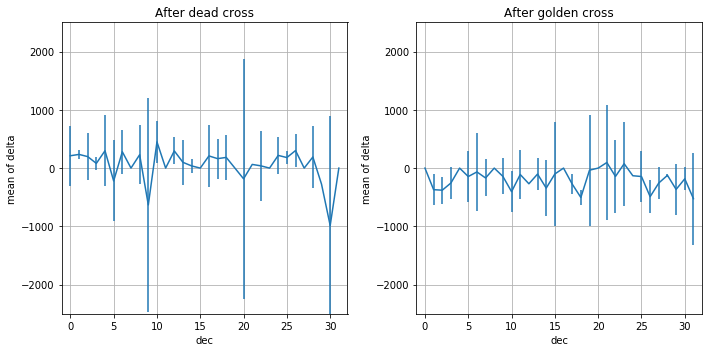

In [17]:
stat_dead = results["stat_dead"]
stat_golden = results["stat_golden"]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.errorbar(np.arange(2**N_dec), stat_dead[:, 2], yerr=stat_dead[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After dead cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.subplot(122)
plt.errorbar(np.arange(2**N_dec), stat_golden[:, 2], yerr=stat_golden[:, 3])
plt.xlabel("dec")
plt.ylabel("mean of delta")
plt.title("After golden cross")
plt.xlim(-1, 2**N_dec)
plt.ylim(-2500, 2500)
plt.grid(True)

plt.tight_layout()

### 箱ひげ図

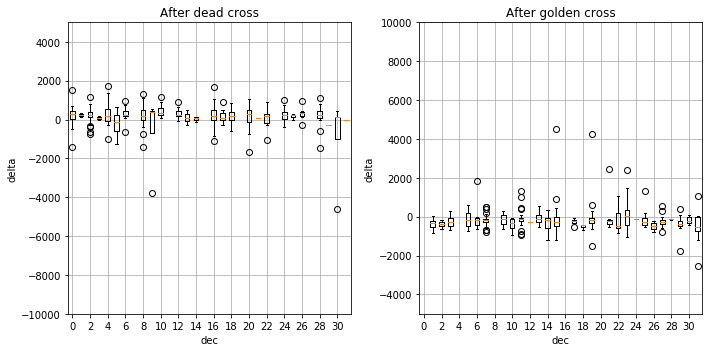

In [18]:
list_ext_dead = results["list_ext_dead"]
list_ext_golden = results["list_ext_golden"]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(tuple(list_ext_dead))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After dead cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-10000, 5000)
plt.grid(True)

plt.subplot(122)
plt.boxplot(tuple(list_ext_golden))
plt.xlabel("dec")
plt.ylabel("delta")
plt.title("After golden cross")
plt.xticks(np.arange(1, 2**N_dec+1, 2), np.arange(0, 2**N_dec, 2))
# plt.xlim(-1, 2**N_dec)
plt.ylim(-5000, 10000)
plt.grid(True)

plt.tight_layout()

## N1とN2を変動させて計算
N1とN2はCombinationで生成する。

In [45]:
N_max= 20

comb_list = []
results_list = []
for x, y in itertools.combinations(np.arange(1, N_max + 1), 2):
    comb_list.append([x, y])
    results_list.append(main(df, x, y, N_dec))

In [30]:
benefits_list = []
for results in results_list:
    benefits_ = results["benefits"]
    dead_ = -benefits_[::2].sum()
    golden_ = benefits_[1::2].sum()
    benefits_list.append([dead_, golden_])

In [31]:
benefits_list

[[-329082, -355233],
 [-285345, -287294],
 [-251852, -260983],
 [-206162, -242730],
 [-198252, -229687],
 [-185561, -204079],
 [-173122, -194028],
 [179073, 164588],
 [-137366, -171633],
 [-128112, -162535],
 [-119013, -146628],
 [142788, 110643],
 [-108930, -136061],
 [-103575, -129303],
 [-95672, -128825],
 [-85837, -118005],
 [-85813, -116728],
 [-80797, -116385],
 [-82526, -113437],
 [-180140, -209166],
 [-168718, -197197],
 [-138762, -173970],
 [-125749, -165129],
 [-108821, -154044],
 [-93144, -138773],
 [129318, 79909],
 [-69008, -128383],
 [-63622, -118407],
 [-57443, -106881],
 [97824, 56143],
 [-56821, -91022],
 [-58986, -92515],
 [-57274, -89233],
 [-61524, -88863],
 [-62063, -89673],
 [-58238, -88142],
 [-59324, -91579],
 [-94205, -142209],
 [-85186, -138770],
 [-88050, -126850],
 [-80932, -116640],
 [-74225, -109495],
 [105217, 73013],
 [-67371, -94227],
 [-61143, -86464],
 [-61140, -87803],
 [88223, 54649],
 [-52094, -88042],
 [-55210, -91704],
 [-49487, -95045],
 [-43943

### ベストな場合

In [36]:
results_list_best = []
for x, y in itertools.combinations(np.arange(1, N_max + 1), 2):
    results_list_best.append(main_peak(df, x, y, N_dec))

In [37]:
benefits_list_best = []
for results in results_list_best:
    benefits_ = results["benefits"]
    dead_ = -benefits_[::2].sum()
    golden_ = benefits_[1::2].sum()
    benefits_list_best.append([dead_, golden_])

In [38]:
benefits_list_best

[[-189712, -281692],
 [-68007, -151616],
 [-6008, -99018],
 [30911, -60936],
 [55173, -32577],
 [81616, -1729],
 [100559, 10054],
 [-25176, -108263],
 [122634, 47218],
 [132038, 57587],
 [139310, 72754],
 [-71286, -144162],
 [148460, 76137],
 [156265, 76996],
 [155455, 76650],
 [157816, 82914],
 [162338, 88284],
 [162293, 83907],
 [160734, 83280],
 [81177, -1342],
 [103916, 19525],
 [132743, 66007],
 [142276, 77610],
 [147757, 79137],
 [163159, 91378],
 [-97085, -171667],
 [171915, 93742],
 [176947, 99868],
 [176424, 107358],
 [-111728, -172897],
 [172947, 114807],
 [168780, 115278],
 [167813, 119991],
 [161260, 107695],
 [160816, 108581],
 [158342, 106957],
 [158922, 105312],
 [136986, 74185],
 [150310, 86371],
 [150404, 86721],
 [151564, 88373],
 [156643, 97621],
 [-98920, -159566],
 [158716, 107737],
 [160139, 112481],
 [148821, 108854],
 [-105645, -151580],
 [151314, 109587],
 [150206, 100375],
 [156051, 98487],
 [155742, 102491],
 [157836, 101989],
 [154425, 106904],
 [146637, 103

### 抽出結果の整理

In [47]:
ary = np.zeros((len(comb_list), 6), dtype=int)
for ii in range(len(comb_list)):
    comb_ = comb_list[ii]
    results_ = benefits_list[ii]
    results_best_ = benefits_list_best[ii]
    ary[ii] = np.array([comb_[0], comb_[1], results_[0], results_[1], results_best_[0], results_best_[1]])

In [48]:
benefits_2d = np.zeros((N_max+1, N_max+1, 2), dtype=int)
benefits_best_2d = np.zeros((N_max+1, N_max+1, 2), dtype=int)

for row in ary:
    benefits_2d[row[0], row[1], 0] = row[2] # dead
    benefits_2d[row[0], row[1], 1] = row[3] # golden
    benefits_best_2d[row[0], row[1], 0] = row[4] # dead
    benefits_best_2d[row[0], row[1], 1] = row[5] # golden

### それぞれの利益の最小値の期待値をイメージプロット

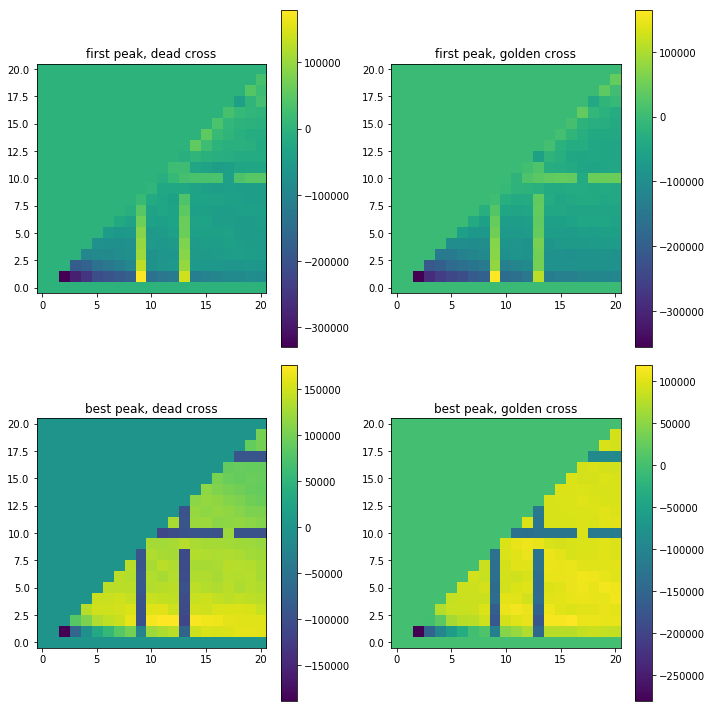

In [53]:
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(benefits_2d[:, :, 0], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("first peak, dead cross")
plt.colorbar()

plt.subplot(222)
plt.imshow(benefits_2d[:, :, 1], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("first peak, golden cross")
plt.colorbar()

plt.subplot(223)
plt.imshow(benefits_best_2d[:, :, 0], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("best peak, dead cross")
plt.colorbar()

plt.subplot(224)
plt.imshow(benefits_best_2d[:, :, 1], origin="normal", interpolation="none")
plt.xlabel("N2")
plt.ylabel("N1")
plt.title("best peak, golden cross")
plt.colorbar()

plt.tight_layout()

### dead + golden のイメージプロット

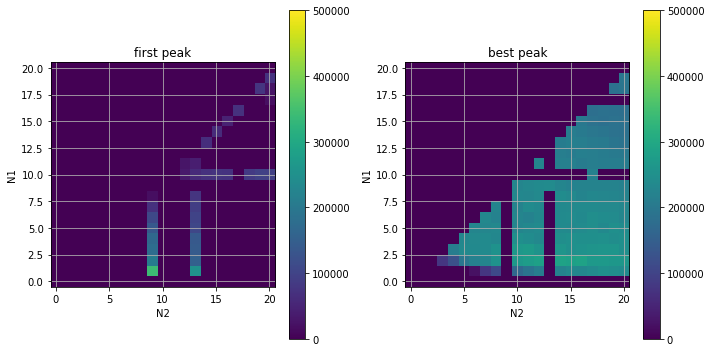

In [67]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(benefits_2d.sum(axis=2), origin="normal", interpolation="none")
plt.title("first peak")
plt.xlabel("N2")
plt.ylabel("N1")
plt.colorbar()
plt.clim(0, 5e5)
plt.grid(True)

plt.subplot(122)
plt.imshow(benefits_best_2d.sum(axis=2), origin="normal", interpolation="none")
plt.title("best peak")
plt.xlabel("N2")
plt.ylabel("N1")
plt.colorbar()
plt.clim(0, 5e5)
plt.grid(True)

plt.tight_layout()
plt.savefig("../images/analysis_of_ohlc(20181224-20181231)-2.png")

In [56]:
print(np.where(benefits_2d.sum(axis=2)==benefits_2d.sum(axis=2).max()), benefits_2d.sum(axis=2).max())
print(np.where(benefits_best_2d.sum(axis=2)==benefits_best_2d.sum(axis=2).max()), benefits_best_2d.sum(axis=2).max())

(array([1], dtype=int64), array([9], dtype=int64)) 343661
(array([2], dtype=int64), array([16], dtype=int64)) 287804


In [66]:
benefits_2d.sum(axis=2)[15, 16]

47725

### 結果の保存

In [64]:
res = dict(
    N_max=N_max, comb_list=comb_list, benefits_list=benefits_list,
    benefits_list_best=benefits_list_best, benefits_2d=benefits_2d,
    benefits_best_2d=benefits_best_2d, ary=ary
)

with open("../data/analysis_of_ohlc(20181224-20181231)-2_res.pickle", "wb") as ff:
    pickle.dump(res, ff)

## まとめ
* ２つのEMAの期間を変化させて、利益の違いを解析した。
* 2018/12/24-2018/12/31の期間では、cross point を越してからのfirst peakで約定した場合とbest peakで約定した場合でほぼ真逆の利益のマップが得られた。
    + first peakの後で約定する場合、 $N_2=9\ or\ 13,\ 1 \leq N_1 \leq 8$ で利益が出た様子。
    + best peakの後で約定する場合、first peak で利益が出た領域以外のほとんどで利益が出た様子。